In [1]:
paste("R version is:", paste0(R.Version()[c("major","minor")], collapse = "."))

[1] "R version is: 4.0.2"

## Predicting outcomes by splitting data

In [2]:
# installing feather library, if not yet available
if (!("feather" %in% rownames(installed.packages()))) {
    install.packages("feather")
}

In [3]:
# installing RCurl library, if not yet available
if (!("RCurl" %in% rownames(installed.packages()))) {
    install.packages("RCurl")
}

The tennis dataset is downloaded from Internet using RCurl and then loaded into memory using the feather library. The feather format is ideal because it can be used by both R and Python, it is fast and compact, and it retains the data types of variables: https://github.com/wesm/feather

In [4]:
library(feather)
library(RCurl)

url <- "https://github.com/lmassaron/datasets/releases/download/1.0/tennis.feather"
destfile <- "tennis.feather"
download.file(url, destfile, mode =  "wb")

tennis <- read_feather(destfile)

Warning message:
"Coercing int64 to double"


In [5]:
# installing rpart library, if not yet available
if (!("rpart" %in% rownames(installed.packages()))) {
    install.packages("rpart")
}

In [6]:
# installing rpart.plot library, if not yet available
if (!("rpart.plot" %in% rownames(installed.packages()))) {
    install.packages("rpart.plot")
}

By setting the control minsplit=1 we allow a complete splitting of the dataset. This makes sense because tennis dataset is a set of rules. In a real world dataset, using the same parameter will certainly lead to overfitting.

In [7]:
library(rpart)
tennis_tree <- rpart(play ~ ., data=tennis, method="class", 
               parms=list(split="information"), control=rpart.control(minsplit=1))


For reading the tree, you start from the top, and for each branch there is condition on data expressed as an equality that can be true or not. When the condition is met, the example takes the left branch, otherwise the right one. Each examples takes different directions depending on its features. When an example reaches a terminal node, you can read inside the node its prediction for all the cases in the node, as well as their distribution which is printed under the mode (negative class on the left, positive class on the right).

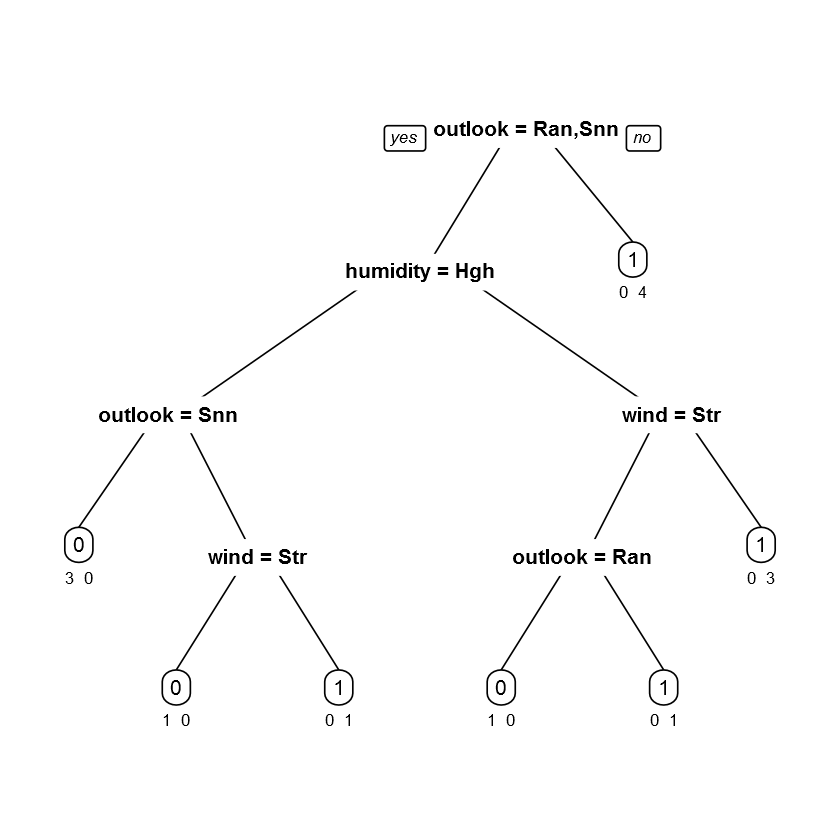

In [8]:
library(rpart.plot)
prp(tennis_tree, type=0, extra=1, under=TRUE, compress=TRUE)

## Pruning overgrown trees

As we mentioned, splitting a tree completely because there is no stopping rule but reaching a terminal node can lead to overfitting. In real world examples you try to keep your tree as simpler as possible. In this example based on the Titanic dataset, we first split the tree until our splits contain more than 5 cases (minsplit=5). 

After we split the tree, we prune it and try to reduce its complexity even more.

In [9]:
data(Titanic, package = "datasets")
dataset <- as.data.frame(Titanic)
library(rpart)
titanic_tree <- rpart(Survived ~ Class + Sex + Age, data=dataset, weights=Freq, method="class", 
                      parms=list(split="information"), control=rpart.control(minsplit=5))
pruned_titanic_tree <- prune(titanic_tree, cp=0.02)

In the end we have a very simple but effective model based on sex and ticket class.

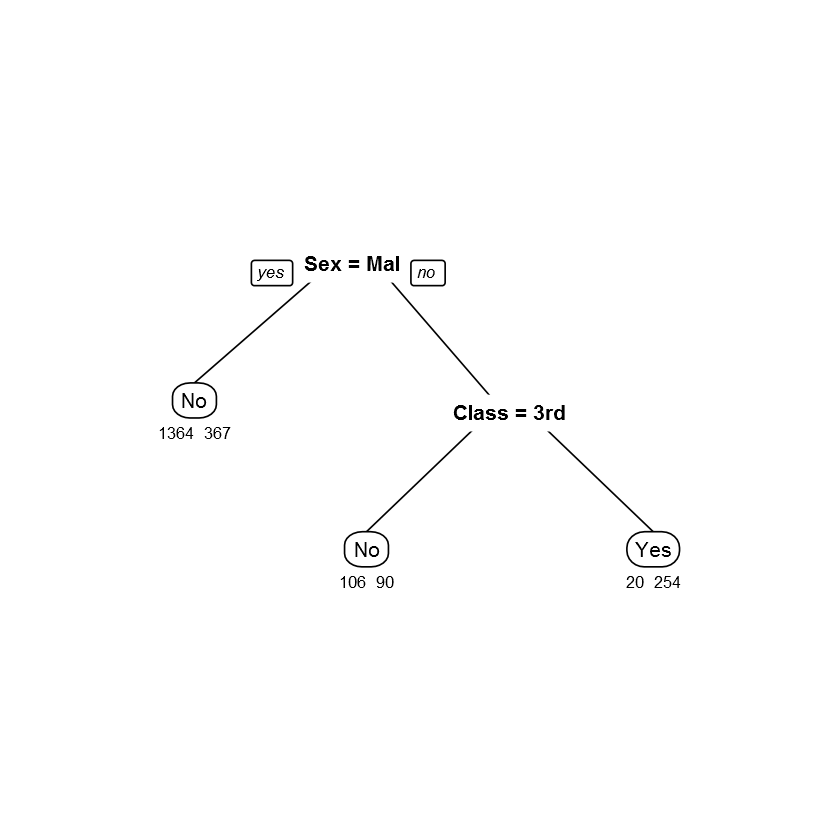

In [10]:
library(rpart.plot)
prp(pruned_titanic_tree, type=0, extra=1, under=TRUE, compress=TRUE)

# Taking a Probabilistic Turn

## Understanding Naïve Bayes

In this example we just demonstrate the calculations happening inside a Naive Bayes classifier.

In [11]:
print(table(tennis$outlook, tennis$play))

          
           0 1
  Overcast 0 4
  Rain     2 3
  Sunny    3 2


In [12]:
outcomes <- table(as.factor(tennis$play))
prob_outcomes <- outcomes / sum(outcomes)
outlook  <- t(as.matrix(table(tennis$outlook, tennis$play))) / as.vector(outcomes)
temperature  <- t(as.matrix(table(tennis$temperature, tennis$play))) / as.vector(outcomes)
humidity  <- t(as.matrix(table(tennis$humidity, tennis$play))) / as.vector(outcomes)
wind  <- t(as.matrix(table(tennis$wind, tennis$play))) / (as.vector(outcomes))

In [13]:
p_positive <- outlook[2, "Sunny"] * temperature[2, "Mild"] * humidity[2, "Normal"] * wind[2, "Weak"] * prob_outcomes[2]

In [14]:
p_negative <- outlook[1, "Sunny"] * temperature[1, "Mild"] * humidity[1, "Normal"] * wind[1, "Weak"] * prob_outcomes[1]

In [15]:
cat(paste("positive proba:", round(p_positive, 3), "| negative proba: ", round(p_negative, 3)))

positive proba: 0.028 | negative proba:  0.007

In [16]:
cat(paste("positive > negative:", p_positive>p_negative))

positive > negative: TRUE

## Estimating response with Naïve Bayes

In [17]:
# installing e1071 library, if not yet available
if (!("e1071" %in% rownames(installed.packages()))) {
    install.packages("e1071")
}

In [18]:
# installing kernel library, if not yet available
if (!("kernlab" %in% rownames(installed.packages()))) {
    install.packages("kernlab")
}

We get the spam data directly from the kernlab library

In [19]:
data(spam, package = "kernlab")

Our training set is sampled from the available data as an index of train cases. using the index we can select the training and validating parts easily.

As parameters of our Naive Bayes estimator we set the prior probabilities of the two classes as 0.9 for not spam and 0.1 for spam. We also set the Laplace correction to 0 meaning that we don't add anything to cell counts before probabilities are computed.

In [20]:
library(e1071)

set.seed(1234) # we set a specific seed for replicability

train_idx <- sample(1:nrow(spam), ceiling(nrow(spam)*3/4), replace=FALSE)
naïve <- naiveBayes(type ~ ., data=spam[train_idx,], 
                    prior = c(0.9, 0.1), fL = 0)

In [21]:
# installing caret library, if not yet available
if (!("caret" %in% rownames(installed.packages()))) {
    install.packages("caret")
}

Here we use the caret library just for printing a confusion matrix and some statistics. The caret library has a variaty of other useful commands when buildign and testing machine learning algorithms. We will discover them in the next chapters. Meanwhile, you can read about the caret library here: https://cran.r-project.org/web/packages/caret/vignettes/caret.html

In [22]:
library(caret)
predictions <- predict(naïve, spam[-train_idx,])
confusionMatrix(as.factor(predictions), spam[-train_idx,"type"])

Loading required package: lattice

Loading required package: ggplot2



Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     382   23
   spam        308  437
                                          
               Accuracy : 0.7122          
                 95% CI : (0.6851, 0.7382)
    No Information Rate : 0.6             
    P-Value [Acc > NIR] : 1.452e-15       
                                          
                  Kappa : 0.4565          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5536          
            Specificity : 0.9500          
         Pos Pred Value : 0.9432          
         Neg Pred Value : 0.5866          
             Prevalence : 0.6000          
         Detection Rate : 0.3322          
   Detection Prevalence : 0.3522          
      Balanced Accuracy : 0.7518          
                                          
       'Positive' Class : nonspam         
               